# **DAAR: Project 1 - Automaton / Clone de la commande egrep**

### Projet réalisé par Antoine LUONG & André VICENTE 


# Imports

In [16]:
import sys
import os
import sys
import subprocess
from graphviz import Digraph
import matplotlib.pyplot as plt
import time
import statistics
import random
import string

# Parser / Lexer

In [2]:
# MACROS
CONCAT = 0xC04CA7
ETOILE = 0xE7011E
ALTERN = 0xA17E54
PROTECTION = 0xBADDAD

PARENTHESEOUVRANT = 0x16641664
PARENTHESEFERMANT = 0x51515151
DOT = 0xD07

# UTILITARY CLASS
class RegExTree:
    def __init__(self, root, subTrees):
        self.root = root
        self.subTrees = subTrees

    def __str__(self):
        if not self.subTrees:
            return self.rootToString()
        result = self.rootToString() + "(" + str(self.subTrees[0])
        for t in self.subTrees[1:]:
            result += "," + str(t)
        result += ")"
        return result

    def rootToString(self):
        if self.root == CONCAT:
            return "."
        if self.root == ETOILE:
            return "*"
        if self.root == ALTERN:
            return "|"
        if self.root == DOT:
            return "."
        return chr(self.root)

# FROM REGEX TO SYNTAX TREE
def parse(regEx):
    # BEGIN DEBUG: set conditionnal to True for debug example
    if False:
        raise Exception()
    example = exampleAhoUllman()
    if False:
        return example
    # END DEBUG

    result = []
    for c in regEx:
        result.append(RegExTree(charToRoot(c), []))
    return parse_recursive(result)

def charToRoot(c):
    if c == '.':
        return DOT
    if c == '*':
        return ETOILE
    if c == '|':
        return ALTERN
    if c == '(':
        return PARENTHESEOUVRANT
    if c == ')':
        return PARENTHESEFERMANT
    return ord(c)

def parse_recursive(result):
    while containParenthese(result):
        result = processParenthese(result)
    while containEtoile(result):
        result = processEtoile(result)
    while containConcat(result):
        result = processConcat(result)
    while containAltern(result):
        result = processAltern(result)
    if len(result) > 1:
        raise Exception()
    return removeProtection(result[0])

def containParenthese(trees):
    for t in trees:
        if t.root == PARENTHESEFERMANT or t.root == PARENTHESEOUVRANT:
            return True
    return False

def processParenthese(trees):
    result = []
    found = False
    for t in trees:
        if not found and t.root == PARENTHESEFERMANT:
            done = False
            content = []
            while not done and result:
                if result[-1].root == PARENTHESEOUVRANT:
                    done = True
                    result.pop()
                else:
                    content.insert(0, result.pop())
            if not done:
                raise Exception()
            found = True
            subTrees = [parse_recursive(content)]
            result.append(RegExTree(PROTECTION, subTrees))
        else:
            result.append(t)
    if not found:
        raise Exception()
    return result

def containEtoile(trees):
    for t in trees:
        if t.root == ETOILE and not t.subTrees:
            return True
    return False

def processEtoile(trees):
    result = []
    found = False
    for t in trees:
        if not found and t.root == ETOILE and not t.subTrees:
            if not result:
                raise Exception()
            found = True
            last = result.pop()
            subTrees = [last]
            result.append(RegExTree(ETOILE, subTrees))
        else:
            result.append(t)
    return result

def containConcat(trees):
    firstFound = False
    for t in trees:
        if not firstFound and t.root != ALTERN:
            firstFound = True
            continue
        if firstFound:
            if t.root != ALTERN:
                return True
            else:
                firstFound = False
    return False

def processConcat(trees):
    result = []
    found = False
    firstFound = False
    for t in trees:
        if not found and not firstFound and t.root != ALTERN:
            firstFound = True
            result.append(t)
            continue
        if not found and firstFound and t.root == ALTERN:
            firstFound = False
            result.append(t)
            continue
        if not found and firstFound and t.root != ALTERN:
            found = True
            last = result.pop()
            subTrees = [last, t]
            result.append(RegExTree(CONCAT, subTrees))
        else:
            result.append(t)
    return result

def containAltern(trees):
    for t in trees:
        if t.root == ALTERN and not t.subTrees:
            return True
    return False

def processAltern(trees):
    result = []
    found = False
    gauche = None
    done = False
    for t in trees:
        if not found and t.root == ALTERN and not t.subTrees:
            if not result:
                raise Exception()
            found = True
            gauche = result.pop()
            continue
        if found and not done:
            if gauche is None:
                raise Exception()
            done = True
            subTrees = [gauche, t]
            result.append(RegExTree(ALTERN, subTrees))
        else:
            result.append(t)
    return result

def removeProtection(tree):
    if tree.root == PROTECTION and len(tree.subTrees) != 1:
        raise Exception()
    if not tree.subTrees:
        return tree
    if tree.root == PROTECTION:
        return removeProtection(tree.subTrees[0])
    subTrees = [removeProtection(t) for t in tree.subTrees]
    return RegExTree(tree.root, subTrees)

def exampleAhoUllman():
    a = RegExTree(ord('a'), [])
    b = RegExTree(ord('b'), [])
    c = RegExTree(ord('c'), [])
    cEtoile = RegExTree(ETOILE, [c])
    dotBCEtoile = RegExTree(CONCAT, [b, cEtoile])
    return RegExTree(ALTERN, [a, dotBCEtoile])

# MAIN
def main():
    ret = parse("a|bc*")
    print(f"  >> Tree result: {ret}.")
       
if __name__ == "__main__":
    main()


  >> Tree result: |(a,.(b,*(c))).


# Construction Automate NDFA

In [3]:
class NDFA:
    def __init__(self):
        self.transitions = {} # state -> symbol -> next_state
        self.start_state = None
        self.accept_states = set()
        self.state_count = 0    

    def new_state(self):
        """
            Cree un nouvel état et retourne son numero
            Complexite: O(1)
        """
        state = self.state_count
        self.state_count += 1
        return state

    def add_transition(self, debut_state, symbol, fin_state):
        """
            Ajoute une transition entre deux etats et le stocke dans le dictionnaire {transitions}
            Complexite: O(1)
            
            debut_state: l'état de départ
            symbol: le symbole de la transition (None pour une transition epsilon)
            fin_state: l'état de fin après la transition
        """
        if debut_state in self.transitions: # transitions[debut_state] != None -> O(1)
            self.transitions[debut_state].append((symbol, fin_state))
        else:
            self.transitions[debut_state] = [(symbol, fin_state)]
            
    def get_alphabet(self):
        """
            Retourne l'alphabet de l'automate, en excluant les epsilon-transitions (None)
            Complexite: O(t) avec t transitions
        """
        alphabet = set()
        for transitions in self.transitions.values():
            for (symbol, _) in transitions:
                if symbol is not None:
                    alphabet.add(symbol)
        return alphabet
    
    # Affichage
    def display(self):
        dot = Digraph()
        for state in range(self.state_count):
            if state in self.accept_states:
                dot.node(str(state), shape="doublecircle")
            else:
                dot.node(str(state))
        for debut_state, edges in self.transitions.items():
            for (symbol, fin_state) in edges:
                label = 'ε' if symbol is None else symbol # symbole sur le graphe
                dot.edge(str(debut_state), str(fin_state), label=label)
        dot.render('ndfa', view=True)

def to_ndfa(tree):
    """
        Construit un automate fini non deterministe a partir de l'arbre syntaxique {tree}
        Complexite: O(n) avec n le nombre de noeuds
    """
    ndfa = NDFA()
    start_state, accept_state = build_ndfa(tree, ndfa)
    ndfa.start_state = start_state
    ndfa.accept_states.add(accept_state)
    return ndfa

def build_ndfa(tree, ndfa):
    """
        Construit recursivement un NDFA base sur l'arbre syntaxique
        Complexite: O(n)
        
        tree: arbre syntaxique representant l'expression reguliere
        ndfa: l'automate en cours de construction
        
        Retourne l'etat de depart et l'etat d'acceptation de l'automate construit pour cette sous-arbre
    """
    # Aho-Ullman
    if tree.subTrees == []:
        # traitement des feuilles
        start = ndfa.new_state()
        end = ndfa.new_state()
        symbol = None if tree.root == DOT else chr(tree.root)
        ndfa.add_transition(start, symbol, end)
        return start, end
    elif tree.root == ETOILE:
        # étoile
        start = ndfa.new_state()
        end = ndfa.new_state()
        ndfa_start, ndfa_end = build_ndfa(tree.subTrees[0], ndfa)
        ndfa.add_transition(start, None, ndfa_start)
        ndfa.add_transition(ndfa_end, None, ndfa_start)
        ndfa.add_transition(ndfa_end, None, end)
        ndfa.add_transition(start, None, end)
        return start, end
    elif tree.root == CONCAT:
        # concatenation
        left_start, left_end = build_ndfa(tree.subTrees[0], ndfa)
        right_start, right_end = build_ndfa(tree.subTrees[1], ndfa)
        ndfa.add_transition(left_end, None, right_start)
        return left_start, right_end
    elif tree.root == ALTERN:
        # alternative
        start = ndfa.new_state()
        end = ndfa.new_state()
        left_start, left_end = build_ndfa(tree.subTrees[0], ndfa)
        right_start, right_end = build_ndfa(tree.subTrees[1], ndfa)
        ndfa.add_transition(start, None, left_start)
        ndfa.add_transition(start, None, right_start)
        ndfa.add_transition(left_end, None, end)
        ndfa.add_transition(right_end, None, end)
        return start, end
    else:
        raise Exception("Unsupported operation")


def main():
    regex = "a|bc*"
    tree = parse(regex)
    print(f"Tree result: {tree}.")
    ndfa = to_ndfa(tree)
    print(f"NDFA created with start state {ndfa.start_state} and accept states {ndfa.accept_states}")
    ndfa.display() # graphe

if __name__ == "__main__":
    main()


Tree result: |(a,.(b,*(c))).
NDFA created with start state 0 and accept states {1}


# DFA Automate Deterministic

In [4]:
class DFA:
    def __init__(self):
        self.transitions = {}  # state -> symbol -> next_state
        self.start_state = None
        self.accept_states = set()
        self.states = set()

    def add_transition(self, debut_state, symbol, fin_state):
        """
            Ajoute une transition entre deux états du DFA avec un symbole
            Complexite: O(1)
        """
        if debut_state not in self.transitions:
            self.transitions[debut_state] = {}
        self.transitions[debut_state][symbol] = fin_state

    # Affichage
    def display(self, filename='dfa'):
        dot = Digraph()
        for state in self.states:
            state_name = self._state_to_string(state)
            if state in self.accept_states: # état sortant: double cercle
                dot.node(state_name, shape="doublecircle")
            else: # état normal
                dot.node(state_name)
        for debut_state, trans in self.transitions.items():
            debut_state_name = self._state_to_string(debut_state)
            for symbol, fin_state in trans.items():
                fin_state_name = self._state_to_string(fin_state)
                dot.edge(debut_state_name, fin_state_name, label=symbol)
        dot.render(filename, view=True)

    # pour display
    def _state_to_string(self, state):
        if isinstance(state, (frozenset, frozenset)):
            return ','.join(map(str, sorted(state)))
        else:
            return str(state)

# Subset Construction Algorithm
def ndfa_to_dfa(ndfa):
    """
        Convertit un NDFA en DFA en utilisant l'algorithme des sous-ensembles
        Complexite: O(2^n*(n^2)), explication sur le rapport partie 2.1.5
    """
    dfa = DFA()
    initial_state = epsilon_closure(ndfa, set([ndfa.start_state]))
    dfa.start_state = initial_state
    dfa.states.add(initial_state)
    if ndfa.accept_states & initial_state:
        dfa.accept_states.add(initial_state)

    unmarked_states = [initial_state]
    alphabet = ndfa.get_alphabet()

    while unmarked_states:
        current_state = unmarked_states.pop()
        for symbol in alphabet:
            if symbol is None:
                continue
            next_states = move(ndfa, current_state, symbol) # déterminer les prochains états accessibles avec ce symbole
            if not next_states:
                continue
            closure = epsilon_closure(ndfa, next_states) # fermeture epsilon des états atteints
            if closure not in dfa.states:
                dfa.states.add(closure)
                unmarked_states.append(closure)
                if ndfa.accept_states & closure:
                    dfa.accept_states.add(closure)
            dfa.add_transition(current_state, symbol, closure)
    return dfa

def epsilon_closure(ndfa, states):
    """
        Calcule la fermeture epsilon des etats donnes.
        La fermeture epsilon est l'ensemble des etats atteignables par des epsilon-transitions a partir d'un ensemble d'etats
        Complexite: O(n+t) car on doit parcourir chaque etat et chaque transition 
        -> O(n^2) car il y a au plus 2 arcs qui sortent d'un noeud
    """
    tmp = list(states)
    closure = set(states)
    while tmp:
        state = tmp.pop()
        for trans in ndfa.transitions.get(state, []):
            if trans[0] is None and trans[1] not in closure:
                closure.add(trans[1])
                tmp.append(trans[1])
    return frozenset(closure)

def move(ndfa, states, symbol):
    """
        Donne les états accessibles depuis les états {states} à partir du symbole {symbol}
        Complexite: O(n+t) car elle doit verifier toutes les transitions sortant des etats
        -> O(n^2)
    """
    next_states = set()
    for state in states:
        for trans in ndfa.transitions.get(state, []):
            if trans[0] == symbol:
                next_states.add(trans[1])
    return next_states

def main():
    regex = "a|bc*"
    tree = parse(regex)
    print(f"Tree result: {tree}.")
    ndfa = to_ndfa(tree)
    print(f"NDFA created with start state {ndfa.start_state} and accept states {ndfa.accept_states}.")
    #ndfa.display()

    dfa = ndfa_to_dfa(ndfa)
    print(f"DFA created with start state {dfa.start_state} and accept states {dfa.accept_states}.")
    dfa.display()

if __name__ == "__main__":
    main()

Tree result: |(a,.(b,*(c))).
NDFA created with start state 0 and accept states {1}.
DFA created with start state frozenset({0, 2, 4}) and accept states {frozenset({1, 3}), frozenset({1, 5, 6, 7, 8}), frozenset({8, 9, 1, 7})}.


# Minimized DFA

In [5]:
# Fonction principale de minimisation
def minimize_dfa(dfa):
    states = sorted(dfa.states)
    symbols = extract_symbols(dfa)
    paires = initialize_paires(dfa, states)
    mark_distinguishable_pairs(paires, states, symbols, dfa)
    state_sets = merge_indistinguishable_states(paires, states)
    return construct_minimized_dfa(state_sets, dfa, symbols)

# Extraction des symboles
def extract_symbols(dfa):
    symbols = set()
    for transitions in dfa.transitions.values():
        symbols.update(transitions.keys())
    return symbols

# Initialisation de la table des paires
def initialize_paires(dfa, states):
    n = len(states)
    paires = [[False] * n for _ in range(n)]
    # Marquer les paires où un état est acceptant et l'autre non
    for i in range(n):
        for j in range(i + 1, n):
            if (states[i] in dfa.accept_states) != (states[j] in dfa.accept_states):
                paires[i][j] = True
    return paires

# Marquage des paires initialement distinguables
def mark_distinguishable_pairs(paires, states, symbols, dfa):
    n = len(states)
    changed = True
    while changed:
        changed = False
        for i in range(n):
            for j in range(i + 1, n):
                if not paires[i][j]:
                    for symbol in symbols:
                        next_i = dfa.transitions.get(states[i], {}).get(symbol)
                        next_j = dfa.transitions.get(states[j], {}).get(symbol)
                        
                        # Si une transition est manquante dans un état mais pas l'autre
                        if (next_i is None) != (next_j is None):
                            paires[i][j] = True
                            changed = True
                            break
                        
                        if next_i is not None and next_j is not None:
                            idx_i = states.index(next_i)
                            idx_j = states.index(next_j)
                            if idx_i > idx_j:
                                idx_i, idx_j = idx_j, idx_i
                            
                            if paires[idx_i][idx_j]:
                                paires[i][j] = True
                                changed = True
                                break

# Fusion des états indiscernables
def merge_indistinguishable_states(paires, states):
    n = len(states)
    state_sets = []
    for i in range(n):
        found = False
        for state_set in state_sets:
            representative = next(iter(state_set))
            rep_idx = states.index(representative)
            pair = (min(i, rep_idx), max(i, rep_idx))
            if not paires[pair[0]][pair[1]]:
                state_set.add(states[i])
                found = True
                break
        if not found:
            state_sets.append({states[i]})
    return state_sets

# Construction du DFA minimisé
def construct_minimized_dfa(state_sets, original_dfa, symbols):
    state_mapping = {state: idx for idx, state_set in enumerate(state_sets) for state in state_set}
    minimized_dfa = DFA()
    
    for idx, state_set in enumerate(state_sets):
        minimized_dfa.states.add(idx)
        if original_dfa.start_state in state_set:
            minimized_dfa.start_state = idx
        if original_dfa.accept_states & state_set:
            minimized_dfa.accept_states.add(idx)
    
    for idx, state_set in enumerate(state_sets):
        representative = next(iter(state_set))
        for symbol in symbols:
            next_state = original_dfa.transitions.get(representative, {}).get(symbol)
            if next_state is not None:
                to_state = state_mapping[next_state]
                minimized_dfa.add_transition(idx, symbol, to_state)
    
    return minimized_dfa

def main():
    regex = "a|bc*"
    tree = parse(regex)
    print(f"Tree result: {tree}.")
    nfa = to_ndfa(tree)
    print(f"NFA created with start state {nfa.start_state} and accept states {nfa.accept_states}.")

    dfa = ndfa_to_dfa(nfa)
    print(f"DFA created with start state {dfa.start_state} and accept states {dfa.accept_states}.")
    
    minimized_dfa = minimize_dfa(dfa)
    print(f"Minimized DFA created with start state {minimized_dfa.start_state} and accept states {minimized_dfa.accept_states}.")
    minimized_dfa.display()

if __name__ == "__main__":
    main()


Tree result: |(a,.(b,*(c))).
NFA created with start state 0 and accept states {1}.
DFA created with start state frozenset({0, 2, 4}) and accept states {frozenset({1, 3}), frozenset({1, 5, 6, 7, 8}), frozenset({8, 9, 1, 7})}.
Minimized DFA created with start state 0 and accept states {1, 2}.


# Text filtré 


In [6]:
def search_regex_in_text(dfa, text):
    matches = []
    text_length = len(text)
    symbols = set()
    for transitions in dfa.transitions.values():
        symbols.update(transitions.keys())

    for start_pos in range(text_length):
        current_state = dfa.start_state
        position = start_pos
        while position < text_length:
            symbol = text[position]
            if symbol not in symbols:
                break  # caractère non reconnu
            if symbol in dfa.transitions.get(current_state, {}):
                current_state = dfa.transitions[current_state][symbol]
                if current_state in dfa.accept_states:
                    # correspondance trouvée de start_pos à position
                    match = text[start_pos:position+1]
                    matches.append((start_pos, position+1, match))
                    break # on break sur le premier match
            else:
                break  # plus de transition possible pour "symbol"
            position += 1
    return matches

#Test de l'algorithme de recherche complet
def main():
    regex = "ccc"
    tree = parse(regex)
    nfa = to_ndfa(tree)
    dfa = ndfa_to_dfa(nfa)
    minimized_dfa = minimize_dfa(dfa)

    text = "abccc ab a bc ccc bcc"
    matches = search_regex_in_text(minimized_dfa, text)
    for start, end, match in matches:
        print(f"Correspondance trouvée: '{match}' de la position {start} à {end}")

if __name__ == "__main__":
    main()


Correspondance trouvée: 'ccc' de la position 2 à 5
Correspondance trouvée: 'ccc' de la position 14 à 17


# KMP

In [7]:
def compute_lps(pattern):
    lps = [0] * len(pattern)
    length = 0  # longueur du précédent plus long préfixe suffixe
    i = 1
    while i < len(pattern):
        if pattern[i] == pattern[length]:
            length += 1
            lps[i] = length
            i += 1
        else:
            if length != 0:
                length = lps[length - 1]
            else:
                lps[i] = 0
                i += 1
    return lps

def kmp_search(text, pattern):
    matches = []
    lps = compute_lps(pattern)
    i = j = 0  # index pour text et pattern
    while i < len(text):
        if text[i] == pattern[j]:
            i += 1
            j += 1
        if j == len(pattern):
            matches.append(i - j)
            j = lps[j - 1]
        elif i < len(text) and text[i] != pattern[j]:
            if j != 0:
                j = lps[j - 1]
            else:
                i += 1
    return matches

def egrep_KMP(pattern, file_path):
    lps = compute_lps(pattern)

    matches = []

    # Parcourir le fichier ligne par ligne
    with open(file_path, 'r', encoding='utf-8') as file:
        for line_num, line in enumerate(file, 1):
            line = line.strip()
            if kmp_search_avec_lps(line, pattern, lps):
                matches.append((line_num, line))

    return matches

def kmp_search_avec_lps(text, pattern, lps):
    i = j = 0  # index pour text et pattern
    while i < len(text):
        if text[i] == pattern[j]:
            i += 1
            j += 1
        if j == len(pattern):
            return True  # Pattern trouvé, on peut arrêter
        elif i < len(text) and text[i] != pattern[j]:
            if j != 0:
                j = lps[j - 1]
            else:
                i += 1
    return False  # Si le pattern n'a pas été trouvé

def main():
    pattern = "abc"
    text = "ababcabcababc"
    matches = kmp_search(text, pattern)
    for index in matches:
        print(f"Correspondance trouvée à la position {index}")

if __name__ == "__main__":
    main()


Correspondance trouvée à la position 2
Correspondance trouvée à la position 5
Correspondance trouvée à la position 10


# EGREP DFA, KMP et bash

In [14]:
def build_dfa(pattern):
    tree = parse(pattern)
    nfa = to_ndfa(tree)
    dfa = ndfa_to_dfa(nfa)
    minimized_dfa = minimize_dfa(dfa)
    return minimized_dfa

def egrep_automate(dfa, lines):
    matches = []
    for line_num, line in enumerate(lines, 1):
        found_matches = search_regex_in_text(dfa, line)
        if found_matches:
            matches.append((line_num, line, found_matches))
    return matches

def egrep_KMP(pattern, lines, lps):
    matches = []
    for line_num, line in enumerate(lines, 1):
        if kmp_search_avec_lps(line, pattern, lps):
            matches.append((line_num, line))
    return matches

# pas tres realiste pour les tests comme on passe par python pour appeler egrep de bash
# on peut enlever le bash_path pour eviter de ralentir le temps d'execution si on n'execute pas sur Windows
def egrep_bash(pattern, file_path):
    """
        Exécute la commande egrep de Git Bash une seule fois pour éviter les surcoûts répétitifs.
    """
    bash_path = r"C:\Program Files\Git\bin\bash.exe"  # Chemin vers bash.exe dans Git Bash
    egrep_command = f"egrep '{pattern}' '{file_path}'"

    try:
        start_time = time.perf_counter()
        result = subprocess.run([bash_path, '-c', egrep_command], capture_output=True, text=True)
        end_time = time.perf_counter()

        if result.returncode == 0: # 0 = trouvé, 1 = non trouvé
            output_lines = result.stdout.strip().split('\n')
            return output_lines, (end_time - start_time)
        else:
            return [], (end_time - start_time)
    except Exception as e:
        print(f"Erreur lors de l'exécution de egrep_bash : {e}")
        return [], None
    
def egrep_automate_file(dfa, file_path):
    matches = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line_num, line in enumerate(file, 1):
            found_matches = search_regex_in_text(dfa, line.strip())
            if found_matches:
                matches.append((line_num, line.strip(), found_matches))
    return matches

def egrep_KMP_file(pattern, file_path, lps):
    matches = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line_num, line in enumerate(file, 1):
            if kmp_search_avec_lps(line.strip(), pattern, lps):
                matches.append((line_num, line.strip()))
    return matches

In [10]:
#test
if __name__ == "__main__":
    pattern = "Sargon"
    file_path = os.path.abspath("test.txt")
    matches = egrep_bash(pattern, file_path)

    print(matches)

print(matches)

(['Here is a line with the word Sargon.', 'Another line that contains the word Sargon.', 'Sargon is also here.'], 0.10877479999908246)
(['Here is a line with the word Sargon.', 'Another line that contains the word Sargon.', 'Sargon is also here.'], 0.10877479999908246)


# Tests Performances

### Mesure de performance pour la recherche de texte (egrep) entre DFA et KMP

In [21]:
def create_test_files():
    """
        Cree 10 fichiers de test avec des lignes vides et le mot 'Sargon' toutes les 5 lignes
        Les fichiers ont entre 100 et 1000 lignes, incrementant de 100 lignes a chaque fichier
    """
    base_dir = 'test_files'
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)
    
    for num_lines in range(100, 15000, 100):
        file_name = os.path.join(base_dir, f'test_{num_lines}.txt')
        with open(file_name, 'w', encoding='utf-8') as f:
            for i in range(1, num_lines + 1):
                if i % 5 == 0:
                    f.write('This line contains Sargon.\n')
                else:
                    f.write('This is an empty line.\n')
        print(f"Fichier {file_name} créé avec {num_lines} lignes.")

create_test_files()

Fichier test_files\test_100.txt créé avec 100 lignes.
Fichier test_files\test_200.txt créé avec 200 lignes.
Fichier test_files\test_300.txt créé avec 300 lignes.
Fichier test_files\test_400.txt créé avec 400 lignes.
Fichier test_files\test_500.txt créé avec 500 lignes.
Fichier test_files\test_600.txt créé avec 600 lignes.
Fichier test_files\test_700.txt créé avec 700 lignes.
Fichier test_files\test_800.txt créé avec 800 lignes.
Fichier test_files\test_900.txt créé avec 900 lignes.
Fichier test_files\test_1000.txt créé avec 1000 lignes.
Fichier test_files\test_1100.txt créé avec 1100 lignes.
Fichier test_files\test_1200.txt créé avec 1200 lignes.
Fichier test_files\test_1300.txt créé avec 1300 lignes.
Fichier test_files\test_1400.txt créé avec 1400 lignes.
Fichier test_files\test_1500.txt créé avec 1500 lignes.
Fichier test_files\test_1600.txt créé avec 1600 lignes.
Fichier test_files\test_1700.txt créé avec 1700 lignes.
Fichier test_files\test_1800.txt créé avec 1800 lignes.
Fichier te

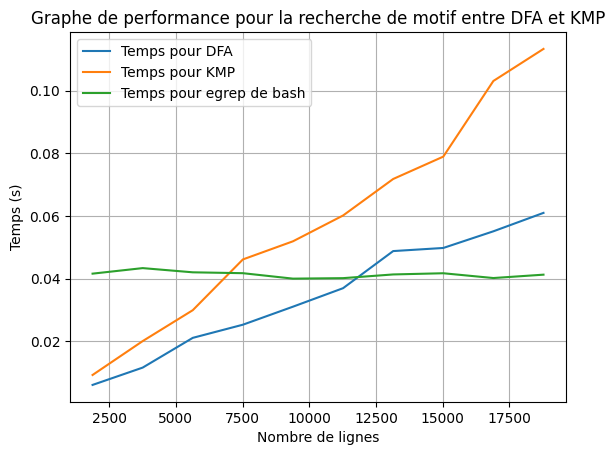

In [22]:
def performance_test(file_path, pattern):
    line_counts = []
    automate_times = []
    kmp_times = []
    bash_times = []

    with open(file_path, 'r', encoding='utf-8') as file:
        all_lines = [line.strip() for line in file]

    total_lines = len(all_lines)
    step = max(total_lines // 10, 1)

    dfa = build_dfa(pattern)
    lps = compute_lps(pattern)

    for lines in range(step, total_lines + 1, step):
        current_lines = all_lines[:lines]

        start_time = time.perf_counter()
        egrep_automate(dfa, current_lines)
        automate_time = time.perf_counter() - start_time

        start_time = time.perf_counter()
        egrep_KMP(pattern, current_lines, lps)
        kmp_time = time.perf_counter() - start_time

        start_time = time.perf_counter()
        try:
            egrep_bash(pattern, file_path)
        except Exception as e:
            print(f"Erreur lors de l'exécution de egrep_bash : {e}", file=sys.stderr)
            bash_time = None
        else:
            bash_time = time.perf_counter() - start_time

        line_counts.append(lines)
        automate_times.append(automate_time)
        kmp_times.append(kmp_time)
        bash_times.append(bash_time)

    plt.plot(line_counts, automate_times, label='Temps pour DFA')
    plt.plot(line_counts, kmp_times, label='Temps pour KMP')
    plt.plot(line_counts, bash_times, label='Temps pour egrep de bash')
    plt.xlabel('Nombre de lignes')
    plt.ylabel('Temps (s)')
    plt.title('Graphe de performance pour la recherche de motif entre DFA et KMP')
    plt.legend()
    plt.grid(True)
    plt.show()

file_path = 'babylon.txt' # babylon.txt pour que le livre de Babylon, babylon_pony.txt pour Babylon et Pony Tracks
pattern = "Sargon"
performance_test(file_path, pattern)

Test avec 100 lignes : DFA = 0.0004 s, KMP = 0.0003 s, egrep_bash = 0.0391 s
Test avec 200 lignes : DFA = 0.0006 s, KMP = 0.0005 s, egrep_bash = 0.0371 s
Test avec 300 lignes : DFA = 0.0017 s, KMP = 0.0008 s, egrep_bash = 0.0377 s
Test avec 400 lignes : DFA = 0.0020 s, KMP = 0.0011 s, egrep_bash = 0.0376 s
Test avec 500 lignes : DFA = 0.0021 s, KMP = 0.0013 s, egrep_bash = 0.0371 s
Test avec 600 lignes : DFA = 0.0022 s, KMP = 0.0015 s, egrep_bash = 0.0368 s
Test avec 700 lignes : DFA = 0.0026 s, KMP = 0.0018 s, egrep_bash = 0.0381 s
Test avec 800 lignes : DFA = 0.0027 s, KMP = 0.0020 s, egrep_bash = 0.0372 s
Test avec 900 lignes : DFA = 0.0030 s, KMP = 0.0024 s, egrep_bash = 0.0385 s
Test avec 1000 lignes : DFA = 0.0031 s, KMP = 0.0026 s, egrep_bash = 0.0409 s
Test avec 1100 lignes : DFA = 0.0033 s, KMP = 0.0031 s, egrep_bash = 0.0399 s
Test avec 1200 lignes : DFA = 0.0035 s, KMP = 0.0031 s, egrep_bash = 0.0377 s
Test avec 1300 lignes : DFA = 0.0037 s, KMP = 0.0034 s, egrep_bash = 0.03

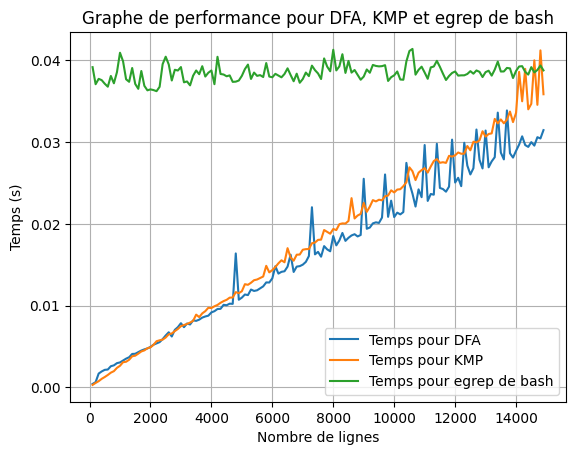

In [23]:
# ici tous les egrep prennent en parametre le fichier pour paraitre comme le egrep de bash
# les fichiers tests sont dans le dossier test_files, on calcule 5 fois le temps pour chaque nombre de lignes pour une moyenne

nb_lines = 15000 # max des fichiers tests

def performance_test(pattern, repetitions=5):
    line_counts = []
    automate_times = []
    kmp_times = []
    bash_times = []

    base_dir = 'test_files'

    for num_lines in range(100, nb_lines, 100):
        file_path = os.path.join(base_dir, f'test_{num_lines}.txt')

        dfa = build_dfa(pattern)
        lps = compute_lps(pattern)

        automate_repeats = []
        kmp_repeats = []
        bash_repeats = []

        for _ in range(repetitions):
            start_time = time.perf_counter()
            egrep_automate_file(dfa, file_path)
            automate_repeats.append(time.perf_counter() - start_time)

            start_time = time.perf_counter()
            egrep_KMP_file(pattern, file_path, lps)
            kmp_repeats.append(time.perf_counter() - start_time)

            start_time = time.perf_counter()
            egrep_bash(pattern, file_path)
            bash_repeats.append(time.perf_counter() - start_time)

        automate_time = statistics.mean(automate_repeats)
        kmp_time = statistics.mean(kmp_repeats)
        bash_time = statistics.mean(bash_repeats)

        line_counts.append(num_lines)
        automate_times.append(automate_time)
        kmp_times.append(kmp_time)
        bash_times.append(bash_time)

        print(f"Test avec {num_lines} lignes : DFA = {automate_time:.4f} s, KMP = {kmp_time:.4f} s, egrep_bash = {bash_time:.4f} s")

    plt.plot(line_counts, automate_times, label='Temps pour DFA')
    plt.plot(line_counts, kmp_times, label='Temps pour KMP')
    plt.plot(line_counts, bash_times, label='Temps pour egrep de bash')
    plt.xlabel('Nombre de lignes')
    plt.ylabel('Temps (s)')
    plt.title('Graphe de performance pour DFA, KMP et egrep de bash')
    plt.legend()
    plt.grid(True)
    plt.show()
pattern = "Sargon"
performance_test(pattern)


Test avec 100 lignes : DFA = 0.0027 s, KMP = 0.0012 s, egrep_bash = 0.0110 s
Test avec 200 lignes : DFA = 0.0025 s, KMP = 0.0013 s, egrep_bash = 0.0090 s
Test avec 300 lignes : DFA = 0.0031 s, KMP = 0.0032 s, egrep_bash = 0.0090 s
Test avec 400 lignes : DFA = 0.0062 s, KMP = 0.0028 s, egrep_bash = 0.0080 s
Test avec 500 lignes : DFA = 0.0065 s, KMP = 0.0031 s, egrep_bash = 0.0070 s
Test avec 600 lignes : DFA = 0.0049 s, KMP = 0.0037 s, egrep_bash = 0.0090 s
Test avec 700 lignes : DFA = 0.0061 s, KMP = 0.0046 s, egrep_bash = 0.0110 s
Test avec 800 lignes : DFA = 0.0056 s, KMP = 0.0055 s, egrep_bash = 0.0090 s
Test avec 900 lignes : DFA = 0.0073 s, KMP = 0.0058 s, egrep_bash = 0.0080 s
Test avec 1000 lignes : DFA = 0.0072 s, KMP = 0.0062 s, egrep_bash = 0.0120 s
Test avec 1100 lignes : DFA = 0.0096 s, KMP = 0.0067 s, egrep_bash = 0.0090 s
Test avec 1200 lignes : DFA = 0.0077 s, KMP = 0.0072 s, egrep_bash = 0.0080 s
Test avec 1300 lignes : DFA = 0.0102 s, KMP = 0.0080 s, egrep_bash = 0.01

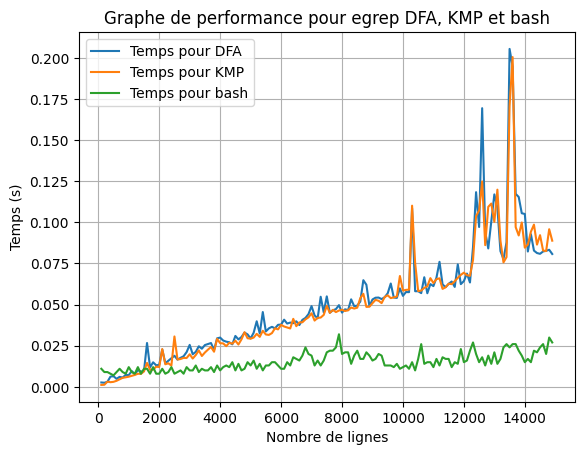

In [24]:
# au lieu d'utiliser python, on utilise bash pour recuperer les temps de egrep
# le script bash est dans le f ichier "egrep", les resultats dans le  fichier "egrep_performance_results.txt"
def load_bash_times(file_path):
    bash_times = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            # On ignore les lignes vides ou mal formees
            if not line.strip():
                continue
            try:
                # format: num_lines, time
                num_lines, elapsed_time = line.strip().split(", ")
                bash_times[int(num_lines)] = float(elapsed_time)
            except ValueError:
                print(f"Format incorrect trouvé dans le fichier pour la ligne : {line.strip()}")
                continue
    return bash_times

def performance_test(pattern, result_file, repetitions=5):
    line_counts = []
    automate_times = []
    kmp_times = []
    bash_times = []

    base_dir = 'test_files'

    # on load les temps du fichier
    bash_performance = load_bash_times(result_file)

    for num_lines in range(100, 15000, 100):
        file_path = os.path.join(base_dir, f'test_{num_lines}.txt')

        dfa = build_dfa(pattern)
        lps = compute_lps(pattern)

        automate_repeats = []
        kmp_repeats = []

        for _ in range(repetitions):
            start_time = time.perf_counter()
            egrep_automate_file(dfa, file_path)
            automate_repeats.append(time.perf_counter() - start_time)

            start_time = time.perf_counter()
            egrep_KMP_file(pattern, file_path, lps)
            kmp_repeats.append(time.perf_counter() - start_time)

        automate_time = statistics.mean(automate_repeats)
        kmp_time = statistics.mean(kmp_repeats)
        bash_time = bash_performance.get(num_lines, None)

        line_counts.append(num_lines)
        automate_times.append(automate_time)
        kmp_times.append(kmp_time)
        bash_times.append(bash_time)

        print(f"Test avec {num_lines} lignes : DFA = {automate_time:.4f} s, KMP = {kmp_time:.4f} s, egrep_bash = {bash_time:.4f} s")

    plt.plot(line_counts, automate_times, label='Temps pour DFA')
    plt.plot(line_counts, kmp_times, label='Temps pour KMP')
    plt.plot(line_counts, bash_times, label='Temps pour bash')
    plt.xlabel('Nombre de lignes')
    plt.ylabel('Temps (s)')
    plt.title('Graphe de performance pour egrep DFA, KMP et bash')
    plt.legend()
    plt.grid(True)
    plt.show()

result_file = "egrep_performance_results.txt"
pattern = "Sargon"
performance_test(pattern, result_file)

### Mesure de performance pour la construction du mini-DFA en fonction de la longueur de l'ERE

Mesure pour le motif de longueur 1: S(a|r|l|z)rg
Temps de construction: 0.001057 secondes
Nombre d'états dans le DFA: 5
Mesure pour le motif de longueur 2: S(a|r|l|z)(a|r|l|z)rg
Temps de construction: 0.000588 secondes
Nombre d'états dans le DFA: 6
Mesure pour le motif de longueur 3: S(a|r|l|z)(a|r|l|z)(a|r|l|z)rg
Temps de construction: 0.001116 secondes
Nombre d'états dans le DFA: 7
Mesure pour le motif de longueur 4: S(a|r|l|z)(a|r|l|z)(a|r|l|z)(a|r|l|z)rg
Temps de construction: 0.001287 secondes
Nombre d'états dans le DFA: 8
Mesure pour le motif de longueur 5: S(a|r|l|z)(a|r|l|z)(a|r|l|z)(a|r|l|z)(a|r|l|z)rg
Temps de construction: 0.002692 secondes
Nombre d'états dans le DFA: 9
Mesure pour le motif de longueur 6: S(a|r|l|z)(a|r|l|z)(a|r|l|z)(a|r|l|z)(a|r|l|z)(a|r|l|z)rg
Temps de construction: 0.002518 secondes
Nombre d'états dans le DFA: 10
Mesure pour le motif de longueur 7: S(a|r|l|z)(a|r|l|z)(a|r|l|z)(a|r|l|z)(a|r|l|z)(a|r|l|z)(a|r|l|z)rg
Temps de construction: 0.003799 secondes


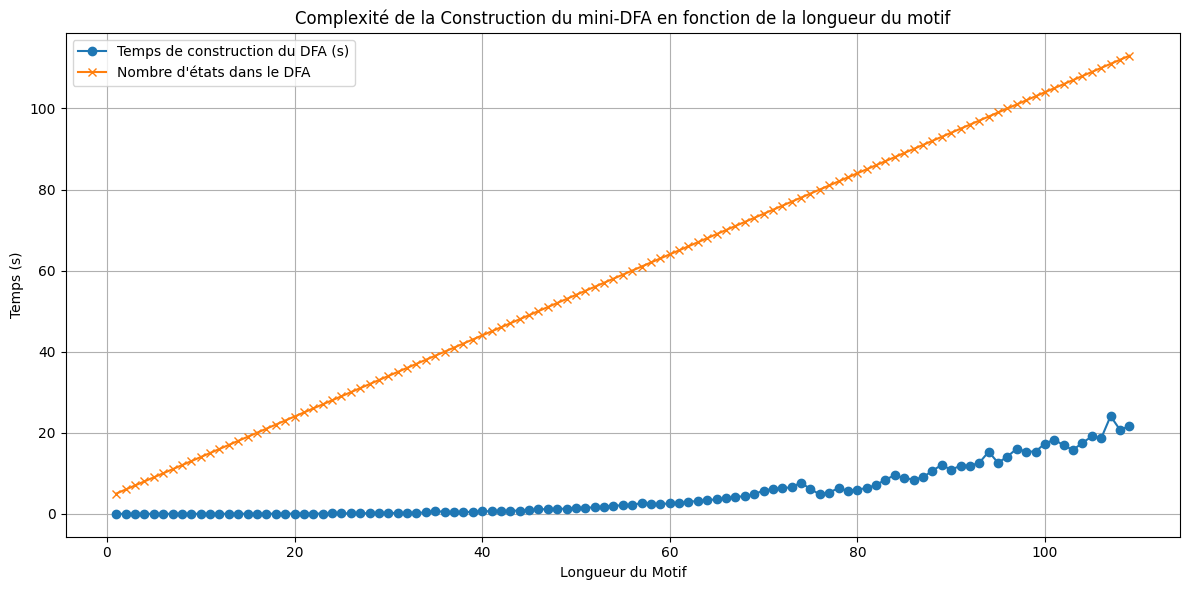

In [23]:
def genere_regex(length):
    """
        Génère un motif regex valide de la forme:
        S(a|r|l|z)rg, S(a|r|l|z)(a|r|l|z)rg, ..., jusqu'à length
    """
    altern = '(a|r|l|z)'
    pattern = 'S' + altern * length + 'rg'
    return pattern

def dfa_construction_time(pattern):
    """
        Mesure le temps nécessaire pour construire un DFA à partir d'une expression regulière
    """
    try:
        start_time = time.perf_counter()
        dfa = build_dfa(pattern)
        end_time = time.perf_counter()
        construction_time = end_time - start_time
        num_states = len(dfa.states)
        return construction_time, num_states
    except Exception as e:
        print(f"Erreur lors de la construction de l'automate pour le pattern '{pattern}': {e}", file=sys.stderr)
        return None, None

def main():
    lengths = list(range(1, 110))
    construction_times = []
    num_states_list = []

    for length in lengths:
        pattern = genere_regex(length)
        print(f"Mesure pour le motif de longueur {length}: {pattern}")
        construction_time, num_states = dfa_construction_time(pattern)
        if construction_time is not None:
            construction_times.append(construction_time)
            num_states_list.append(num_states)
            print(f"Temps de construction: {construction_time:.6f} secondes")
            print(f"Nombre d'états dans le DFA: {num_states}")
        else:
            construction_times.append(None)
            num_states_list.append(None)
            print(f"Construction échouée pour le motif de longueur {length}")

    # Filtrer les résultats valides
    valid_lengths = [i for i, j in zip(lengths, construction_times) if j is not None]
    valid_times = [i for i in construction_times if i is not None]
    valid_num_states = [i for i in num_states_list if i is not None]

    # graphique du temps de construction et du nombre d'etats
    plt.figure(figsize=(12, 6))

    plt.plot(valid_lengths, valid_times, marker='o', label='Temps de construction du DFA (s)')
    plt.plot(valid_lengths, valid_num_states, marker='x', label='Nombre d\'états dans le DFA')

    plt.xlabel('Longueur du Motif')
    plt.ylabel('Temps (s)')
    plt.title('Complexité de la Construction du mini-DFA en fonction de la longueur du motif')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

Lignes traitées: 1000, Motif: 'the', mDFA: 0.0221s
Lignes traitées: 1000, Motif: 'S.rgon', mDFA: 0.0383s
Lignes traitées: 1000, Motif: 'S(a|z|y|c|b|a|j|y)rg*nS(a|z|y|c|b|a|j|y)r.(a|z|y|g|b|a|j|y)n', mDFA: 0.6972s
Lignes traitées: 1000, Motif: 'S(a|z|y|c|b|a|j|y)(a|z|y|g|b|a|j|y|r).(a|z|y|g|b|a|j|y)n', mDFA: 0.9679s
Lignes traitées: 1000, Motif: 'Sargada', mDFA: 0.0545s
Lignes traitées: 2000, Motif: 'the', mDFA: 0.0411s
Lignes traitées: 2000, Motif: 'S.rgon', mDFA: 0.0753s
Lignes traitées: 2000, Motif: 'S(a|z|y|c|b|a|j|y)rg*nS(a|z|y|c|b|a|j|y)r.(a|z|y|g|b|a|j|y)n', mDFA: 1.3512s
Lignes traitées: 2000, Motif: 'S(a|z|y|c|b|a|j|y)(a|z|y|g|b|a|j|y|r).(a|z|y|g|b|a|j|y)n', mDFA: 1.9716s
Lignes traitées: 2000, Motif: 'Sargada', mDFA: 0.1105s
Lignes traitées: 3000, Motif: 'the', mDFA: 0.0657s
Lignes traitées: 3000, Motif: 'S.rgon', mDFA: 0.1208s
Lignes traitées: 3000, Motif: 'S(a|z|y|c|b|a|j|y)rg*nS(a|z|y|c|b|a|j|y)r.(a|z|y|g|b|a|j|y)n', mDFA: 2.0275s
Lignes traitées: 3000, Motif: 'S(a|z|y|c|b|

C:\Users\andre\AppData\Local\Temp\ipykernel_14284\1641018250.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(patterns))


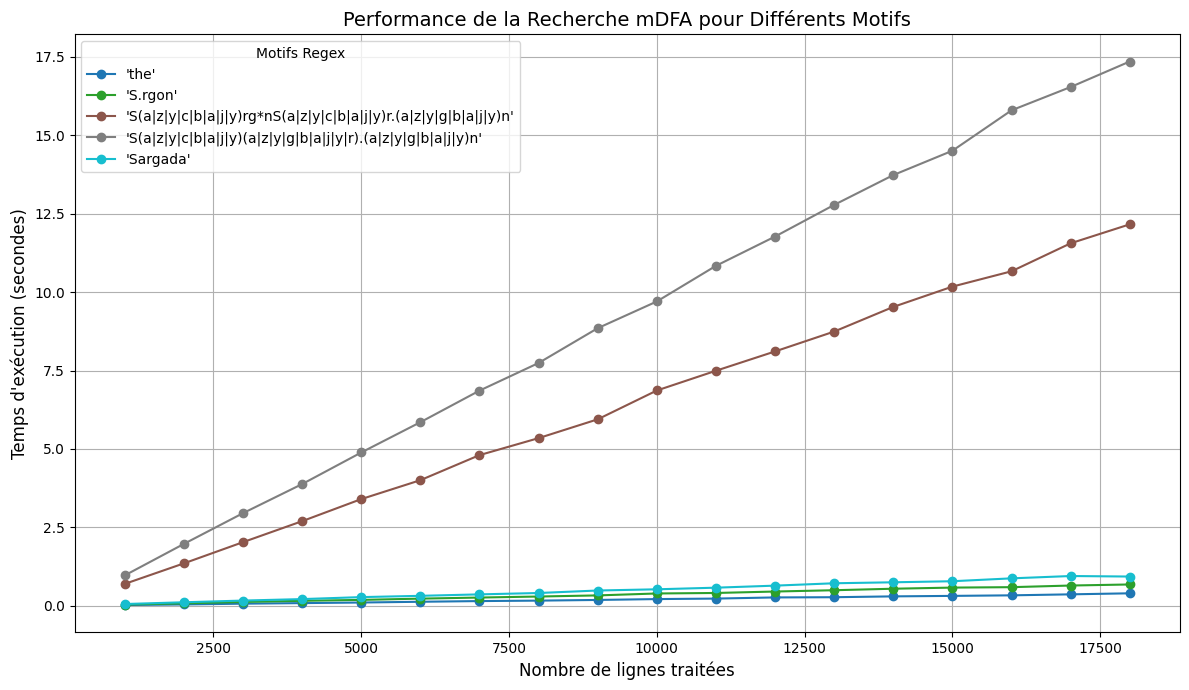

In [61]:
def analyze_performance_mdfa(file_path, patterns, max_lines=None, step=1000):
    """
    Analyse la performance de la recherche de motifs en utilisant mDFA pour plusieurs regex.

    :param file_path: Chemin vers le fichier texte.
    :param patterns: Liste de motifs d'expression régulière à rechercher.
    :param max_lines: Nombre maximal de lignes à traiter (None pour tout traiter).
    :param step: Intervalle d'incrémentation du nombre de lignes traitées.
    """
    lines_processed = []
    mdfa_times = {pattern: [] for pattern in patterns}

    with open(file_path, 'r', encoding='utf-8') as file:
        lines = []
        for line_num, line in enumerate(file, 1):
            lines.append(line.strip())
            if max_lines and line_num >= max_lines:
                break
            if line_num % step == 0 or line_num == max_lines:
                text = "\n".join(lines)
                lines_processed.append(line_num)

                for pattern in patterns:
                    # Mesurer le temps pour mDFA
                    start_time = time.time()
                    tree = parse(pattern)
                    nfa = to_ndfa(tree)
                    dfa = ndfa_to_dfa(nfa)
                    minimized_dfa = minimize_dfa(dfa)
                    for l in lines:
                        matches = search_regex_in_text(minimized_dfa, l)
                    
                    mdfa_time = time.time() - start_time
                    mdfa_times[pattern].append(mdfa_time)

    plt.figure(figsize=(12, 7))
    colors = plt.cm.get_cmap('tab10', len(patterns))

    # une courbe pour chaque motif
    for idx, pattern in enumerate(patterns):
        plt.plot(
            lines_processed,
            mdfa_times[pattern],
            label=f"'{pattern}'",
            marker='o',
            color=colors(idx)
        )

    plt.xlabel('Nombre de lignes traitées', fontsize=12)
    plt.ylabel('Temps d\'exécution (secondes)', fontsize=12)
    plt.title('Performance de la Recherche mDFA pour Différents Motifs', fontsize=14)
    plt.legend(title='Motifs Regex')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def main():
    file_path = 'babylon.txt'  
    patterns = [
        'the',
        'S.rgon',         
        'S(a|z|y|c|b|a|j|y)rg*n'
        'S(a|z|y|c|b|a|j|y)r.(a|z|y|g|b|a|j|y)n',
        'S(a|z|y|c|b|a|j|y)(a|z|y|g|b|a|j|y|r).(a|z|y|g|b|a|j|y)n',
        'Sargada'
    ]  
    max_lines = None           
    step = 1000                
    analyze_performance_mdfa(file_path, patterns, max_lines, step)
if __name__ == "__main__":
    main()

C:\Users\andre\AppData\Local\Temp\ipykernel_11876\3579457864.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(patterns))


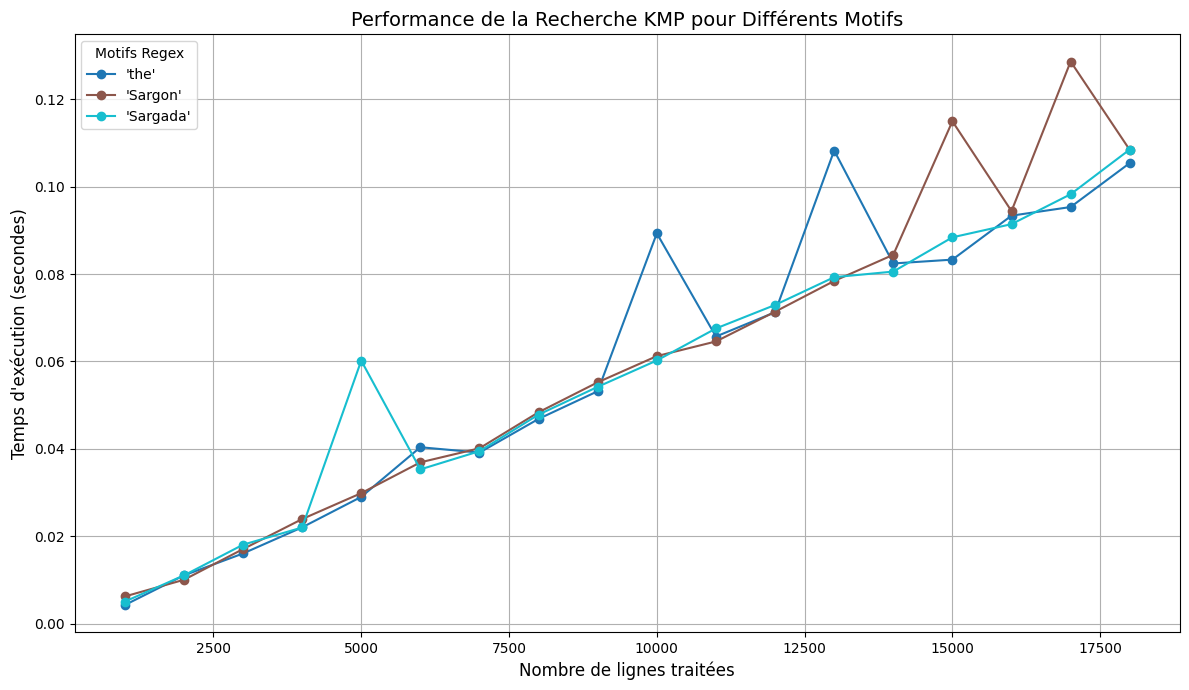

In [27]:
def analyze_performance_kmp(file_path, patterns, max_lines=None, step=1000):
    """
    Analyse la performance de la recherche de motifs en utilisant kmp pour plusieurs regex.

    :param file_path: Chemin vers le fichier texte.
    :param patterns: Liste de motifs d'expression régulière à rechercher.
    :param max_lines: Nombre maximal de lignes à traiter (None pour tout traiter).
    :param step: Intervalle d'incrémentation du nombre de lignes traitées.
    """
    lines_processed = []
    mdfa_times = {pattern: [] for pattern in patterns}

    with open(file_path, 'r', encoding='utf-8') as file:
        lines = []
        for line_num, line in enumerate(file, 1):
            lines.append(line.strip())
            if max_lines and line_num >= max_lines:
                break

            if line_num % step == 0 or line_num == max_lines:
               
                text = "\n".join(lines)
                lines_processed.append(line_num)

                # Parcourir chaque motif regex
                for pattern in patterns:
                    start_time = time.time()
                    kmp_matches = [kmp_search(l, pattern) for l in lines]
                    mdfa_time = time.time() - start_time
                    mdfa_times[pattern].append(mdfa_time)


    plt.figure(figsize=(12, 7))
    colors = plt.cm.get_cmap('tab10', len(patterns))

    # une courbe pour chaque motif 
    for idx, pattern in enumerate(patterns):
        plt.plot(
            lines_processed,
            mdfa_times[pattern],
            label=f"'{pattern}'",
            marker='o',
            color=colors(idx)
        )

    # config du graph
    plt.xlabel('Nombre de lignes traitées', fontsize=12)
    plt.ylabel('Temps d\'exécution (secondes)', fontsize=12)
    plt.title('Performance de la Recherche KMP pour Différents Motifs', fontsize=14)
    plt.legend(title='Motifs Regex')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def main():
    file_path = 'babylon.txt' 
    patterns = [
        'the',
        'Sargon',
        'Sargada',
    ]  
    max_lines = None          
    step = 1000                 
    analyze_performance_kmp(file_path, patterns, max_lines, step)
if __name__ == "__main__":
    main()

## Etude du pire cas

In [20]:
# toujours dans le dossier test_files, on cree des fichiers de test pour les pires cas, et des fichiers
# normaux pour comparer les performances dont la longueur des lignes est à peu pres la meme
def generate_worst_case_dfa(num_lines):
    """
        Genere un fichier "pire cas" pour DFA
    """
    base_dir = 'test_files'
    os.makedirs(base_dir, exist_ok=True)
    file_path = os.path.join(base_dir, f'test_dfa_worst_{num_lines}.txt')
    
    with open(file_path, 'w', encoding='utf-8') as f:
        for _ in range(num_lines):
            f.write('ABCDE' * 20 + '\n')  # tout le temps alterner
    return file_path

def generate_worst_case_kmp(num_lines):
    """
        Genere un fichier "pire cas" pour KMP
    """
    base_dir = 'test_files'
    os.makedirs(base_dir, exist_ok=True)
    file_path = os.path.join(base_dir, f'test_kmp_worst_{num_lines}.txt')
    
    with open(file_path, 'w', encoding='utf-8') as f:
        for _ in range(num_lines):
            f.write('A' * 100 + '\n')  # repetitions
    return file_path

def generate_normal_case(num_lines):
    """
        Genere un fichier avec des donnees normales, sans motif particulier
    """
    base_dir = 'test_files'
    os.makedirs(base_dir, exist_ok=True)
    file_path = os.path.join(base_dir, f'test_normal_{num_lines}.txt')
    
    with open(file_path, 'w', encoding='utf-8') as f:
        for _ in range(num_lines):
            # caracteres aleatoires
            line = ''.join(random.choices(string.ascii_uppercase + ' ', k=100))
            f.write(line + '\n')
    return file_path

Normal avec 100 lignes : DFA = 0.0035 s, KMP = 0.0031 s
Pire cas avec 100 lignes : DFA = 0.0076 s, KMP = 0.0051 s
Normal avec 200 lignes : DFA = 0.0057 s, KMP = 0.0056 s
Pire cas avec 200 lignes : DFA = 0.0213 s, KMP = 0.0092 s
Normal avec 300 lignes : DFA = 0.0066 s, KMP = 0.0075 s
Pire cas avec 300 lignes : DFA = 0.0156 s, KMP = 0.0100 s
Normal avec 400 lignes : DFA = 0.0176 s, KMP = 0.0221 s
Pire cas avec 400 lignes : DFA = 0.0336 s, KMP = 0.0231 s
Normal avec 500 lignes : DFA = 0.0129 s, KMP = 0.0156 s
Pire cas avec 500 lignes : DFA = 0.0452 s, KMP = 0.0230 s
Normal avec 600 lignes : DFA = 0.0170 s, KMP = 0.0230 s
Pire cas avec 600 lignes : DFA = 0.0387 s, KMP = 0.0251 s
Normal avec 700 lignes : DFA = 0.0111 s, KMP = 0.0159 s
Pire cas avec 700 lignes : DFA = 0.0320 s, KMP = 0.0215 s
Normal avec 800 lignes : DFA = 0.0139 s, KMP = 0.0206 s
Pire cas avec 800 lignes : DFA = 0.0404 s, KMP = 0.0296 s
Normal avec 900 lignes : DFA = 0.0150 s, KMP = 0.0224 s
Pire cas avec 900 lignes : DFA =

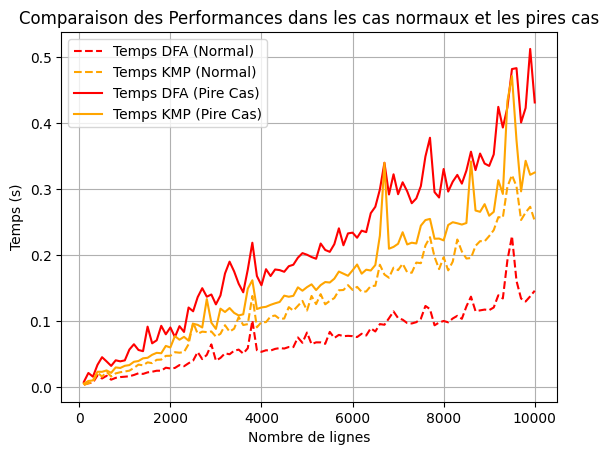

In [27]:
def performance_test_worst_case(pattern, repetitions=5):
    line_counts = []
    automate_times_normal = []
    kmp_times_normal = []
    automate_times_worst = []
    kmp_times_worst = []

    for num_lines in range(100, 10001, 100):
        file_path_normal = generate_normal_case(num_lines)  # Cas normal
        file_path_kmp_worst = generate_worst_case_kmp(num_lines)  # Pire cas pour KMP
        file_path_dfa_worst = generate_worst_case_dfa(num_lines)  # Pire cas pour DFA

        dfa_normal = build_dfa(pattern)
        lps_normal = compute_lps(pattern)

        automate_repeats_normal = []
        kmp_repeats_normal = []
        automate_repeats_worst = []
        kmp_repeats_worst = []

        for _ in range(repetitions):
            # Test normal pour DFA et KMP
            start_time = time.perf_counter()
            egrep_automate_file(dfa_normal, file_path_normal)
            automate_repeats_normal.append(time.perf_counter() - start_time)

            start_time = time.perf_counter()
            egrep_KMP_file(pattern, file_path_normal, lps_normal)
            kmp_repeats_normal.append(time.perf_counter() - start_time)

            # Pire cas pour DFA
            start_time = time.perf_counter()
            egrep_automate_file(build_dfa(pattern), file_path_dfa_worst)
            automate_repeats_worst.append(time.perf_counter() - start_time)

            # Pire cas pour KMP
            start_time = time.perf_counter()
            egrep_KMP_file(pattern, file_path_kmp_worst, compute_lps(pattern))
            kmp_repeats_worst.append(time.perf_counter() - start_time)

        automate_times_normal.append(statistics.mean(automate_repeats_normal))
        kmp_times_normal.append(statistics.mean(kmp_repeats_normal))
        automate_times_worst.append(statistics.mean(automate_repeats_worst))
        kmp_times_worst.append(statistics.mean(kmp_repeats_worst))
        line_counts.append(num_lines)

        print(f"Normal avec {num_lines} lignes : DFA = {automate_times_normal[-1]:.4f} s, KMP = {kmp_times_normal[-1]:.4f} s")
        print(f"Pire cas avec {num_lines} lignes : DFA = {automate_times_worst[-1]:.4f} s, KMP = {kmp_times_worst[-1]:.4f} s")

    plt.plot(line_counts, automate_times_normal, label='Temps DFA (Normal)', linestyle='--', color='red')
    plt.plot(line_counts, kmp_times_normal, label='Temps KMP (Normal)', linestyle='--', color='orange')
    plt.plot(line_counts, automate_times_worst, label='Temps DFA (Pire Cas)', color='red')
    plt.plot(line_counts, kmp_times_worst, label='Temps KMP (Pire Cas)', color='orange')

    plt.xlabel('Nombre de lignes')
    plt.ylabel('Temps (s)')
    plt.title('Comparaison des Performances dans les cas normaux et les pires cas')
    plt.legend()
    plt.grid(True)
    plt.show()

pattern = "ABC"
performance_test_worst_case(pattern)
